In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! gdown "1xfqhYYmeVVbbemn-5Vwpol0Z-nnUemWG"  # OSACT2022-sharedTask-train.csv
! gdown "18FIG-1QrCN58VZW4dYlPOJblPabjHRm1"  # OSACT2022-sharedTask-dev.csv
! gdown "1GStA7e0LgjjqYmoXFH6I8tsgjYy3x-LT"  # OSACT2022-sharedTask-test-tweets.csv
! gdown "1OjrLjr6lZmAYWmGOyhJlHpN-Dh5R5hpS"  # OSACT2022-sharedTask-test-taskA-gold-labels.txt
! gdown "165kzfZDsRTZAAfZKedeZiUlKzMcHNgPd"  # Arabic_stop_words.txt

Downloading...
From: https://drive.google.com/uc?id=1xfqhYYmeVVbbemn-5Vwpol0Z-nnUemWG
To: /content/OSACT2022-sharedTask-train.csv
100% 1.51M/1.51M [00:00<00:00, 33.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=18FIG-1QrCN58VZW4dYlPOJblPabjHRm1
To: /content/OSACT2022-sharedTask-dev.csv
100% 212k/212k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GStA7e0LgjjqYmoXFH6I8tsgjYy3x-LT
To: /content/OSACT2022-sharedTask-test-tweets.csv
100% 351k/351k [00:00<00:00, 38.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OjrLjr6lZmAYWmGOyhJlHpN-Dh5R5hpS
To: /content/OSACT2022-sharedTask-test-taskA-gold-labels.txt
100% 16.8k/16.8k [00:00<00:00, 49.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=165kzfZDsRTZAAfZKedeZiUlKzMcHNgPd
To: /content/Arabic_stop_words.txt
100% 6.48k/6.48k [00:00<00:00, 27.7MB/s]


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for emoji: filename=emoji-2.7.0-py2.py3-none-any.whl size=356563 sha256=e45426e096a39e7673e4743c4b21452426a30aaae045c75002fac02023833232
  Stored in directory: /root/.cache/pip/wheels/41/11/48/5df0b9727d5669c9174a141134f10304d1d78a3b89a4676f3d
Successfully built emoji


In [ ]:
import emoji
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# to view the full outputs
pd.set_option('display.max_colwidth', None)

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/IRI/"

## Data:

### Data loading

In [ ]:
columns = [
    "id",
    "tweet",
    "Offensive",     # Offensive & NotOffensive
    "Hate Speech",   # Hate Speech [Gender, Race, Ideology, Social Class, Religion, Disability]
    "Vulgar",        # Vulgar
    "Violence"       # Violence
    ]

In [ ]:
train = pd.read_csv("OSACT2022-sharedTask-train.csv")
train.columns = columns
train.set_index("id", inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8886 entries, 2 to 8887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        8886 non-null   object
 1   Offensive    8886 non-null   object
 2   Hate Speech  8886 non-null   object
 3   Vulgar       8886 non-null   object
 4   Violence     8886 non-null   object
dtypes: object(5)
memory usage: 416.5+ KB


In [ ]:
train.head(10)

,tweet,Offensive,Hate Speech,Vulgar,Violence
id,,,,,
2,وصارت فطاير البقالات غذاء صحي 👎🏻 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
3,@USER روحي لبريده تلقين اشباه كثير بس ماحد زيكم مشفوح يخقخق ويطالعهم بكل انحطاط ويصورهم الله يفشلكم بس😷,OFF,NOT_HS,NOT_VLG,NOT_VIO
4,@USER مش باين حاجه خالص 😣<LF>مش عارف بقى 😔,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
5,"#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمين <LF>عندهم خاله اسمها امل<LF>👏أو عمه امل <LF>👏او اخت امل<LF>👏او زوجه امل<LF>👏او بنت امل<LF>✊او حماة امل<LF>👊واللي ماعنده ولا امل<LF>بالعائلة يراجع نفسه لانه وضعه مو طبيعي/😳<LF>وأي قروب فيه ""امل"" هو من أسعد القروبات<LF>اذا عندكم وحده اسمها امل ارسلوها لها😽😻",NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
6,حمدلله ماحطها في فمي اساسا😷🤢 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
7,@USER هههه 😂🌚🤢,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8,#بايع_الكليجا اللي مايضحك من هالمقطع يبلكني هههههههه مطططههببللللل 😂😂😂👌👌👊👊😍😍😩😩😂😂 يمثلني ههههههه 😂😂👊 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
9,خلاص الله يزعجكم خلللاص 😷😷 #بايع_الكليجا,OFF,NOT_HS,NOT_VLG,NOT_VIO
10,@USER هيلق و جحلط غير كذا مافي 😷,OFF,NOT_HS,NOT_VLG,NOT_VIO


In [ ]:
print(train["Offensive"].value_counts(),'\n')
print(train["Hate Speech"].value_counts(),'\n')
print(train["Vulgar"].value_counts(),'\n')
print(train["Violence"].value_counts(),'\n')

NOT_OFF    5715
OFF        3171
Name: Offensive, dtype: int64 

NOT_HS    7927
HS6        456
HS1        260
HS3        144
HS5         72
HS2         27
Name: Hate Speech, dtype: int64 

NOT_VLG    8752
VLG         134
Name: Vulgar, dtype: int64 

NOT_VIO    8825
VIO          61
Name: Violence, dtype: int64 



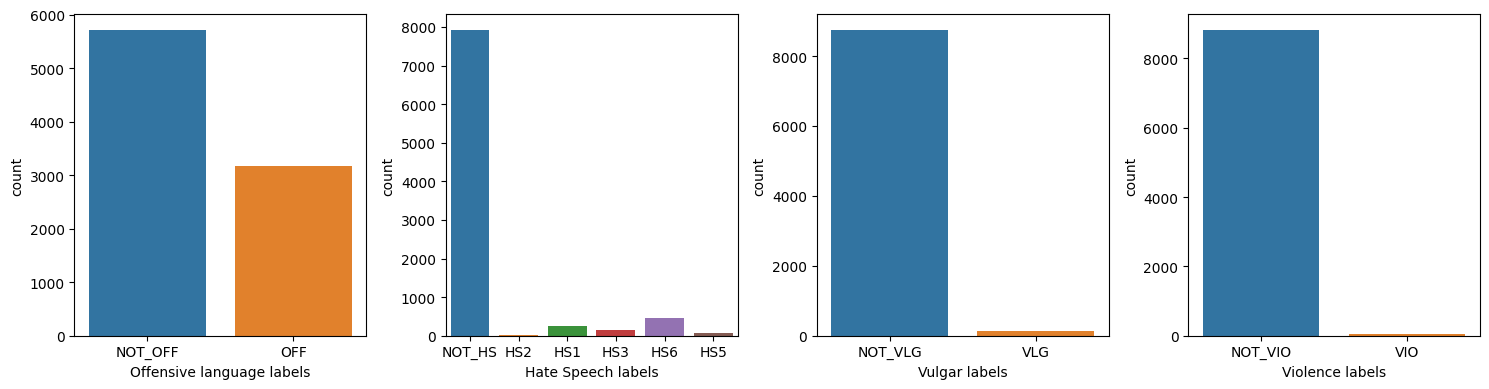

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
sns.countplot(data=train, x='Offensive', ax=axes[0])
axes[0].set_xlabel('Offensive language labels')
sns.countplot(data=train, x='Hate Speech', ax=axes[1])
axes[1].set_xlabel('Hate Speech labels')
sns.countplot(data=train, x='Vulgar', ax=axes[2])
axes[2].set_xlabel('Vulgar labels')
sns.countplot(data=train, x='Violence', ax=axes[3])
axes[3].set_xlabel('Violence labels')
plt.tight_layout()
plt.show()

In [ ]:
dev = pd.read_csv("OSACT2022-sharedTask-dev.csv")
dev.columns = columns
dev.set_index("id", inplace=True)
dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1269 entries, 8889 to 10157
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        1269 non-null   object
 1   Offensive    1269 non-null   object
 2   Hate Speech  1269 non-null   object
 3   Vulgar       1269 non-null   object
 4   Violence     1269 non-null   object
dtypes: object(5)
memory usage: 59.5+ KB


In [ ]:
dev.head(10)

,tweet,Offensive,Hate Speech,Vulgar,Violence
id,,,,,
8889,#داليا_مبارك<LF>مادري ليش تقرفت😷,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8890,RT @USER ابديت السناب الجديد ❌<LF>حاس الناس حوس ،أشوف مشاهير. تضيفني، مشاهير تتابع يومياتي ، ابديت كرهني بالسناب كله 😤,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8891,@USER هييه والله وااايدد 🔪🔪🔪💔💔,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8892,اكيد اخس شي 😤 URL,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8893,مابي شي الحين غير فراشي😣,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8894,RT @USER اقسم بالله عيب اللي يصير 😷,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8895,@USER اه هذا واش عندوا زيادة 😠😠😠,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8896,@USER اذكر الله يامل الحتسه🙄👊,NOT_OFF,NOT_HS,NOT_VLG,NOT_VIO
8897,RT @USER ابتلشت بالقرد 🐒 😅<LF>القرد عاد نفسه فرد من العائله ! 😬 URL,OFF,NOT_HS,NOT_VLG,NOT_VIO


In [ ]:
test = pd.read_csv("OSACT2022-sharedTask-test-tweets.csv")
test.columns = ["id", "tweet"]
label_offensive = pd.read_csv("OSACT2022-sharedTask-test-taskA-gold-labels.txt")
label_offensive.columns = ["Offensive"]
test = test.join(label_offensive)
test.set_index("id", inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540 entries, 10159 to 12698
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      2540 non-null   object
 1   Offensive  2540 non-null   object
dtypes: object(2)
memory usage: 59.5+ KB


In [ ]:
test.head(10)

,tweet,Offensive
id,,
10159,مشفتش العرض بتاعهم لا مش مهتمة لا😩🐸😂 URL,NOT_OFF
10160,RT @USER عندما تكون لوحدك تحس انك لحالك صح 😊<LF><LF>حتى انا مثلك 🌚😂😂😂😂<LF>🐸💔✋<LF>#بــدايه شغاله<LF>مولعه<LF>@USER <LF>عدد 000,NOT_OFF
10161,RT @USER ماشاء الله الرجال باين عليه محترم <LF>البنات متى تعقلوا 😡<LF><LF>#بايع_الكليجا,NOT_OFF
10162,@USER شسالفة احد يفهمني 😤,NOT_OFF
10163,@USER اقووووول استريح عاد احتفالاتنا تحط اغانينا 😡😡,NOT_OFF
10164,اليوم قالت التيتشر بما أنكم مقبلين تكونون أمهات ، تنكدت ما أبي أحد يذكرني ..<LF>وطبعًا المجتمع اللعين ما راح يرحمني إذا ما تزوجت 😷 ..,NOT_OFF
10165,@USER <LF>الحقه يامحمود وخده عند اي دكتور 😂😂😂👊,NOT_OFF
10166,@USER اوووف اوووف اوووووووف<LF><LF>شقد احبهم .... شقد احبهم ... سودا عليه <LF><LF>وتبغدد علينا 😣,NOT_OFF
10167,غراب🔪🔪🔪,NOT_OFF


In [ ]:
train = train[["tweet", "Offensive"]]
dev = dev[["tweet", "Offensive"]]
test = test[["tweet", "Offensive"]]

### Data preprocessing

#### Data cleaning

In [ ]:
# emojis_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IRI/Arabic Offensive Language Detection/emoji_df.csv")
emojis_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IRI/emoji_df.csv")

In [ ]:
emojis_df.head()

,emoji,name,group,sub_group,codepoints,ar_name
0,😀,grinning face,Smileys & Emotion,face-smiling,1F600,الوجه ابتسامة
1,😃,grinning face with big eyes,Smileys & Emotion,face-smiling,1F603,وجه ابتسامة عريضة بعيون كبيرة
2,😄,grinning face with smiling eyes,Smileys & Emotion,face-smiling,1F604,الوجه الابتسامة بعيون مبتسمة
3,😁,beaming face with smiling eyes,Smileys & Emotion,face-smiling,1F601,وجه مبتهج بعيون مبتسمة
4,😆,grinning squinting face,Smileys & Emotion,face-smiling,1F606,ابتسامة عريضة الوجه


In [ ]:
arabic_stop_words=[]
with open ('./Arabic_stop_words.txt',encoding='utf-8') as f :
    for word in f.readlines() :
        arabic_stop_words.append(word.split("\n")[0])

In [ ]:
train['word_count'] = train['tweet'].apply(lambda x: len(str(x).split(" ")))
train['char_count'] = train['tweet'].apply(lambda x: len(x.replace(" ", "")))
train['stopwords'] = train['tweet'].apply(lambda x: len([x for x in x.split() if x in arabic_stop_words]))
train['emoji_count'] = train['tweet'].apply(lambda x: emoji.emoji_count(x))
train['emojis'] = train['tweet'].apply(lambda text: ''.join(re.findall(r'[😀-🙏]', text)))

In [ ]:
train.head()

,tweet,Offensive,word_count,char_count,stopwords,emoji_count,emojis
id,,,,,,,
2,وصارت فطاير البقالات غذاء صحي 👎🏻 URL,NOT_OFF,7,30,0,1,
3,@USER روحي لبريده تلقين اشباه كثير بس ماحد زيكم مشفوح يخقخق ويطالعهم بكل انحطاط ويصورهم الله يفشلكم بس😷,OFF,18,86,0,1,😷
4,@USER مش باين حاجه خالص 😣<LF>مش عارف بقى 😔,NOT_OFF,9,34,0,2,😣😔
5,"#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمين <LF>عندهم خاله اسمها امل<LF>👏أو عمه امل <LF>👏او اخت امل<LF>👏او زوجه امل<LF>👏او بنت امل<LF>✊او حماة امل<LF>👊واللي ماعنده ولا امل<LF>بالعائلة يراجع نفسه لانه وضعه مو طبيعي/😳<LF>وأي قروب فيه ""امل"" هو من أسعد القروبات<LF>اذا عندكم وحده اسمها امل ارسلوها لها😽😻",NOT_OFF,43,261,6,10,😳😽😻
6,حمدلله ماحطها في فمي اساسا😷🤢 URL,NOT_OFF,6,27,1,2,😷


In [ ]:
train.describe()

,word_count,char_count,stopwords,emoji_count
count,8886.000000,8886.000000,8886.000000,8886.000000
mean,12.802611,62.085753,1.855278,2.712807
std,10.063601,49.459916,2.302989,2.990532
min,1.000000,3.000000,0.000000,0.000000
25%,6.000000,26.000000,0.000000,1.000000
50%,10.000000,46.000000,1.000000,2.000000
75%,17.000000,83.000000,3.000000,3.000000
max,144.000000,331.000000,21.000000,65.000000


In [ ]:
emojis_list = set(emoji for emojis in train['emojis'] for emoji in emojis)
emojis_count_dict = {emoji: 0 for emoji in emojis_list}

In [ ]:
def count_emojis(text):
    for char in text:
        if char in emojis_count_dict:
            emojis_count_dict[char] += 1

train['tweet'].apply(lambda text: count_emojis(text))
emojis_count_dict = dict(sorted(emojis_count_dict.items(), key=lambda x: x[1], reverse=True))
emojis_count_dict

{'😂': 3417,
 '😷': 1965,
 '😡': 1506,
 '😤': 870,
 '😣': 687,
 '😠': 500,
 '😭': 325,
 '😒': 251,
 '🙂': 196,
 '😍': 125,
 '🙉': 118,
 '😩': 107,
 '😢': 102,
 '😅': 97,
 '🙈': 93,
 '🙄': 91,
 '😏': 90,
 '😹': 87,
 '😁': 63,
 '😑': 62,
 '😉': 58,
 '😎': 55,
 '😌': 54,
 '🙊': 53,
 '😊': 51,
 '🙃': 51,
 '😬': 51,
 '😜': 50,
 '😔': 50,
 '😕': 50,
 '😳': 50,
 '😧': 38,
 '😱': 37,
 '😞': 36,
 '😆': 35,
 '😐': 35,
 '😪': 35,
 '😥': 34,
 '😈': 29,
 '😖': 28,
 '😃': 26,
 '😲': 24,
 '😄': 24,
 '😀': 23,
 '😝': 23,
 '😋': 23,
 '😘': 23,
 '😫': 23,
 '😓': 23,
 '😴': 22,
 '😇': 22,
 '😛': 19,
 '😰': 18,
 '🙁': 17,
 '😟': 17,
 '🙌': 17,
 '🙏': 16,
 '🙆': 16,
 '😶': 14,
 '🙋': 13,
 '😨': 13,
 '😼': 12,
 '😻': 12,
 '😯': 11,
 '🙀': 9,
 '😦': 8,
 '😮': 7,
 '🙇': 6,
 '😵': 5,
 '😗': 4,
 '🙅': 3,
 '😾': 3,
 '😙': 2,
 '😸': 2,
 '🙎': 2,
 '😽': 1,
 '🙍': 1,
 '😚': 1}

In [ ]:
emoji_mapping = dict(zip(emojis_df["emoji"], emojis_df["ar_name"]))
emoji_mapping

{'😀': 'الوجه ابتسامة',
 '😃': 'وجه ابتسامة عريضة بعيون كبيرة',
 '😄': 'الوجه الابتسامة بعيون مبتسمة',
 '😁': 'وجه مبتهج بعيون مبتسمة',
 '😆': 'ابتسامة عريضة الوجه',
 '😅': 'وجه ابتسامة عرق مع العرق',
 '🤣': 'يتدحرج على الارض من الضحك',
 '😂': 'وجه بدموع الفرح',
 '🙂': 'الوجه المبتسم قليلا',
 '🙃': 'وجه رأسا على عقب',
 '😉': 'الوجه الغطس',
 '😊': 'الوجه المبتسم بعيون مبتسمة',
 '😇': 'الوجه المبتسم مع هالو',
 '🥰': 'الوجه المبتسم بقلوب',
 '😍': 'الوجه المبتسم بعيون القلب',
 '🤩': 'ضرب النجوم',
 '😘': 'وجه يهب قبلة',
 '😗': 'التقبيل الوجه',
 '☺️': 'الوجه المبتسم',
 '☺': 'الوجه المبتسم',
 '😚': 'تقبيل الوجه بعيون مغلقة',
 '😙': 'تقبيل الوجه بعيون مبتسمة',
 '🥲': 'الوجه المبتسم بالدموع',
 '😋': 'وجه تذوق الطعام',
 '😛': 'وجه مع اللسان',
 '😜': 'الوجه الغطس باللسان',
 '🤪': 'الوجه zany',
 '😝': 'وجه التحديق مع اللسان',
 '🤑': 'وجه الفم',
 '🤗': 'الوجه المعانقة',
 '🤭': 'وجه بيده على الفم',
 '🤫': 'وجه شوشينغ',
 '🤔': 'وجه التفكير',
 '🤐': 'سستة الفم الوجه',
 '🤨': 'وجه مع حاجب مرفوع',
 '😐': 'وجه محايد',
 '😑': 'وجه عديمة ال

In [ ]:
emoji_mapping["🤧"]

'الوجه العطس'

In [ ]:
def extract_hashtag(text):
    hashtags = re.findall(r"([\u0600-\u06FF]+)|#(?!\d+\b)\w+", text)
    return " ".join(hashtags)



def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text_without_tags = soup.get_text()
    return text_without_tags


# def replace_arabic_numbers(text):
#     arabic_english_digits = {
#         "٠": "0",
#         "١": "1",
#         "٢": "2",
#         "٣": "3",
#         "٤": "4",
#         "٥": "5",
#         "٦": "6",
#         "٧": "7",
#         "٨": "8",
#         "٩": "9"
#     }
#     for char in text:
#         if char in arabic_english_digits:
#             text = text.replace(char, arabic_english_digits[char])
#     return text


def remove_repeated(text):
    return re.sub(r'(.)\1+', r"\1\1", text)


def replace_emojis_with_text(text):
    for char in text:
        if char in emoji_mapping:
            name = emoji_mapping[char]
            text = text.replace(char, " "+name+" ")
    return text


def ar_normalization(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    tshkel = re.compile(r"ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ")
    text = re.sub(tshkel, '', text)
    return text


def remove_stop_words(text):
    words = text.split(" ")
    for word in words:
        if word in arabic_stop_words:
             text = text.replace(word, "")
    return text


def clean_str(text):
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    # text = replace_arabic_numbers(text)     # arabic numbers
    text = re.sub('@[^\s]+',' ',text)       # mentions
    text = remove_repeated(text)            # repeated more that twice
    text = replace_emojis_with_text(text)   # emojis
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), '', text) #punctuaiotns
    text = ar_normalization(text)
    text = remove_stop_words(text) #stopwords
    text = extract_hashtag(text)            # hashtags
    return text


# normalizing the stop words
for i in range(len(arabic_stop_words)):
    arabic_stop_words[i] = ar_normalization(arabic_stop_words[i])

label2id = {"NOT_OFF": 0, "OFF": 1}
id2label = {0: "NOT_OFF", 1: "OFF"}

In [ ]:
train["tweet_clean"] = train["tweet"].apply(lambda x: clean_str(x))
test["tweet_clean"] = test["tweet"].apply(lambda x: clean_str(x))
dev["tweet_clean"] = dev["tweet"].apply(lambda x: clean_str(x))

In [ ]:
train['class'] = train['Offensive'].apply(lambda x: label2id[x])
dev['class'] = dev['Offensive'].apply(lambda x: label2id[x])
test['class'] = test['Offensive'].apply(lambda x: label2id[x])

In [ ]:
train['word_count_clean'] = train['tweet_clean'].apply(lambda x: len(str(x).split(" ")))
train['char_count_clean'] = train['tweet_clean'].apply(lambda x: len(x.replace(" ", "")))
train.head()

,tweet,Offensive,word_count,char_count,stopwords,emoji_count,emojis,tweet_clean,class,word_count_clean,char_count_clean
id,,,,,,,,,,,
2,وصارت فطاير البقالات غذاء صحي 👎🏻 URL,NOT_OFF,7,30,0,1,,وصارت فطاير البقالات غذاء صحي استهجن,0,6,31
3,@USER روحي لبريده تلقين اشباه كثير بس ماحد زيكم مشفوح يخقخق ويطالعهم بكل انحطاط ويصورهم الله يفشلكم بس😷,OFF,18,86,0,1,😷,روحي لبريده تلقين اشباه كثير بس ماحد زيكم مشفوح يخقخق ويطالعهم بكل انحطاط ويصورهم الله يفشلكم بس وجه مع قناع طبي,1,21,92
4,@USER مش باين حاجه خالص 😣<LF>مش عارف بقى 😔,NOT_OFF,9,34,0,2,😣😔,مش باين حاجه خالص الوجه المثابر مش عارف بقي وجه باهظه,0,11,43
5,"#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمين <LF>عندهم خاله اسمها امل<LF>👏أو عمه امل <LF>👏او اخت امل<LF>👏او زوجه امل<LF>👏او بنت امل<LF>✊او حماة امل<LF>👊واللي ماعنده ولا امل<LF>بالعائلة يراجع نفسه لانه وضعه مو طبيعي/😳<LF>وأي قروب فيه ""امل"" هو من أسعد القروبات<LF>اذا عندكم وحده اسمها امل ارسلوها لها😽😻",NOT_OFF,43,261,6,10,😳😽😻,اليومالاثنين التصفيق يقولك من المسلمين عندهم خاله اسمها امل التصفيق او عمه امل التصفيق او اخت امل التصفيق او زوجه امل التصفيق او بنت امل رفع قبضه او حماه امل قبضه قادمه واللي ماعنده ولا امل بالعاءله يراجع نفسه لانه وضعه مو طبيعي وجه متوهج واي قروب فيه امل هو من اسعد القروبات اذا عندكم وحده اسمها امل ارسلوها لها تقبيل القط قطه مبتسمه مع عيون القلب,0,67,282
6,حمدلله ماحطها في فمي اساسا😷🤢 URL,NOT_OFF,6,27,1,2,😷,حمدلله ماحطها في فمي اساسا وجه مع قناع طبي الوجه الغثيان,0,11,46


In [ ]:
dev.head()

,tweet,Offensive,tweet_clean,class
id,,,,
8889,#داليا_مبارك<LF>مادري ليش تقرفت😷,NOT_OFF,داليامبارك مادري ليش تقرفت وجه مع قناع طبي,0
8890,RT @USER ابديت السناب الجديد ❌<LF>حاس الناس حوس ،أشوف مشاهير. تضيفني، مشاهير تتابع يومياتي ، ابديت كرهني بالسناب كله 😤,NOT_OFF,ابديت السناب الجديد علامه تقاطع حاس الناس حوس اشوف مشاهير تضيفني مشاهير تتابع يومياتي ابديت كرهني بالسناب كله وجه ببخار من الانف,0
8891,@USER هييه والله وااايدد 🔪🔪🔪💔💔,NOT_OFF,هييه والله واايدد سكين المطبخ سكين المطبخ قلب مجروح قلب مجروح,0
8892,اكيد اخس شي 😤 URL,NOT_OFF,اكيد اخس شي وجه ببخار من الانف,0
8893,مابي شي الحين غير فراشي😣,NOT_OFF,مابي شي الحين غير فراشي الوجه المثابر,0


In [ ]:
test.head()

,tweet,Offensive,tweet_clean,class
id,,,,
10159,مشفتش العرض بتاعهم لا مش مهتمة لا😩🐸😂 URL,NOT_OFF,مشفتش العرض بتاعهم لا مش مهتمه لا وجه مرهق ضفدع وجه بدموع الفرح,0
10160,RT @USER عندما تكون لوحدك تحس انك لحالك صح 😊<LF><LF>حتى انا مثلك 🌚😂😂😂😂<LF>🐸💔✋<LF>#بــدايه شغاله<LF>مولعه<LF>@USER <LF>عدد 000,NOT_OFF,عندما تكون لوحدك تحس انك لحالك صح الوجه المبتسم بعيون مبتسمه حتي انا مثلك وجه القمر الجديد وجه بدموع الفرح وجه بدموع الفرح ضفدع قلب مجروح رفعت اليد بدايه شغاله مولعه عدد,0
10161,RT @USER ماشاء الله الرجال باين عليه محترم <LF>البنات متى تعقلوا 😡<LF><LF>#بايع_الكليجا,NOT_OFF,ماشاء الله الرجال باين عليه محترم البنات متي تعقلوا وجه العبوس بايعالكليجا,0
10162,@USER شسالفة احد يفهمني 😤,NOT_OFF,شسالفه احد يفهمني وجه ببخار من الانف,0
10163,@USER اقووووول استريح عاد احتفالاتنا تحط اغانينا 😡😡,NOT_OFF,اقوول استريح عاد احتفالاتنا تحط اغانينا وجه العبوس وجه العبوس,0


In [ ]:
# max tweet length
train['length'] = train['tweet_clean'].apply(lambda x:len(x.split(' ')))
print("Maximum tweet length \n", train['length'].max())
train.query("length > 50")

Maximum tweet length 
 165


,tweet,Offensive,word_count,char_count,stopwords,emoji_count,emojis,tweet_clean,class,word_count_clean,char_count_clean,length
id,,,,,,,,,,,,
5,"#اليوم_الاثنين<LF><LF>👏 يقولك :%90 من المسلمين <LF>عندهم خاله اسمها امل<LF>👏أو عمه امل <LF>👏او اخت امل<LF>👏او زوجه امل<LF>👏او بنت امل<LF>✊او حماة امل<LF>👊واللي ماعنده ولا امل<LF>بالعائلة يراجع نفسه لانه وضعه مو طبيعي/😳<LF>وأي قروب فيه ""امل"" هو من أسعد القروبات<LF>اذا عندكم وحده اسمها امل ارسلوها لها😽😻",NOT_OFF,43,261,6,10,😳😽😻,اليومالاثنين التصفيق يقولك من المسلمين عندهم خاله اسمها امل التصفيق او عمه امل التصفيق او اخت امل التصفيق او زوجه امل التصفيق او بنت امل رفع قبضه او حماه امل قبضه قادمه واللي ماعنده ولا امل بالعاءله يراجع نفسه لانه وضعه مو طبيعي وجه متوهج واي قروب فيه امل هو من اسعد القروبات اذا عندكم وحده اسمها امل ارسلوها لها تقبيل القط قطه مبتسمه مع عيون القلب,0,67,282,67
151,@USER فعلا كلشي بسببها بس يالي قهرني هي بتتكلم و الكاميرا عليها طول الربورتاج بس بارش لا كانو هي النجمة لامعة و بارش الحارس 💂 الشخصي ليش هذا الانحياز في الصحافة ليش نسيو نجومية بارش و شعبيتو في تركيا راحت الهيبة بتاع بارش 😥صحافة تافهة صراحة 😒 👎,OFF,48,197,11,4,😥😒,فعلا كلشي بسببها بس يالي قهرني هي بتتكلم و الكاميرا عليها طول الربورتاج بس بارش لا كانو هي النجمه لامعه و بارش الحارس يحمي الشخصي ليش هذا الانحياز في الصحافه ليش نسيو نجوميه بارش و شعبيتو في تركيا راحت الهيبه بتاع بارش وجه حزين ولكن مرتاح صحافه تافهه صراحه وجه غير مستخدم استهجن,1,53,226,53
179,@USER قاعد تشد وجهك وتلوي فمك وخشمك عشان تبان الغمازه مدري الحفره الي بوجهك 😷 ونظام خالف تعرف عشان رتويت يحمار الغلط غلط على الانثى والذكر مو عشان العيال سوو غلط خلاص البنات يسون مثلهم وثاني شي الرجال ازعجوه برزقه وبالنهايه لو تعصر وجهك من هنا الى بكره م,OFF,49,206,7,1,😷,قاعد تشد وجهك وتلوي فمك وخشمك عشان تبان الغمازه مدري الحفره الي بوجهك وجه مع قناع طبي ونظام خالف تعرف عشان رتويت يحمار الغلط غلط علي الانثي والذكر مو عشان العيال سوو غلط خلاص البنات يسون مثلهم وثاني شي الرجال ازعجوه برزقه وبالنهايه لو تعصر وجهك من هنا الي بكره م,1,51,212,51
400,@USER لسا متخانقة امبارح علشان كلمة الي بيحب ميكرهش دي 💔😂😂 <LF>لا يا جماعة الي بيحب بيكره لو اتجرح و اتذل و اتظلم و اتداس ع كرامته و قلبه 👊👊👊 <LF>و ع قدر الحب يكون الزعل و الكره 💔 <LF>اول ما يبقي مش فارق و زيه زي اي حد يبقي بطل يحبه ✌,NOT_OFF,53,182,14,8,😂😂,لسا متخانقه امبارح علشان كلمه الي بيحب ميكرهش دي قلب مجروح وجه بدموع الفرح وجه بدموع الفرح لا يا جماعه الي بيحب بيكره لو اتجرح و اتذل و اتظلم و اتداس ع كرامته و قلبه قبضه قادمه قبضه قادمه و ع قدر الحب يكون الزعل و الكره قلب مجروح اول ما يبقي مش فارق و زيه زي اي حد يبقي بطل يحبه يد النصر,0,64,224,64
483,حياؤك فاحفظه عليك فإنما<LF>يدلُّ على فضل الكريم حياؤه<LF>إذا قلَّ ماء الوجه قلَّ حيـاؤه<LF>ولا خير في وجهٍ إذا قلَّ ماؤه<LF> اذا انتقدأحدهم تصرفات الفتيات غير المحتشمة مع #بايع_الكليجا قالوا مستشرف🤔يريدوننا مجتمعاً بلا حياء ولا أخلاق تحت مسمى يا تسكت 🙊او نهاجمك😡,OFF,41,223,9,3,🙊😡,حياءك فاحفظه عليك فانما يدل علي فضل الكريم حياءه اذا قل ماء الوجه قل حياءه ولا خير في وجه اذا قل ماءه اذا انتقداحدهم تصرفات الفتيات غير المحتشمه مع بايعالكليجا قالوا مستشرف وجه التفكير يريدوننا مجتمعا بلا حياء ولا اخلاق تحت مسمي يا تسكت يتحدث القرد لا او نهاجمك وجه العبوس,1,51,222,51
...,...,...,...,...,...,...,...,...,...,...,...,...
8600,#بايع_الكليجا<LF>امس في سوق عكاظ تعرضت للتحرش من قبل مجموعة من الدشير حسبي الله ونعم الوكيل<LF>المشكله ماردعهم وجود الشرطه<LF>الله لايوفقهم😣<LF><LF>ليش دخلتم العزابيه علينا ياسوق عكاظ<LF>ليش تسمحون لهم يأذونا😔<LF><LF>هنا تعمدت ماوضح الصورة عشان مااشهر فيهم💩<LF>بس جد قهروني طول الوقت يلاحقوني<LF>حسبي الله URL,OFF,40,270,6,3,😣😔,بايعالكليجا امس في سوق عكاظ تعرضت للتحرش من قبل مجموعه من الدشير حسبي الله ونعم الوكيل المشكله ماردعهم وجود الشرطه الله لايوفقهم الوجه المثابر ليش دخلتم العزابيه علينا ياسوق عكاظ ليش تسمحون لهم ياذونا وجه باهظه هنا تعمدت ماوضح الصوره عشان مااشهر فيهم كومه من البراز بس جد قهروني طول الوقت يلاحقوني حسبي الله,1,54,254,54
8700,كل وحدة تمدح فيه وتصوره وتتغزل<LF>حابة اقولك انتي رخيصة انتي ولا شي انتي غير متربية ولا فيك ذرة خوف من الله وحياء راضية عن نفسك تركضين وراء #بايع_الكليجا وتصوريه او غيره؟؟!!<LF>كيف حياتك وعيشتك والى اي مرحلة من ا

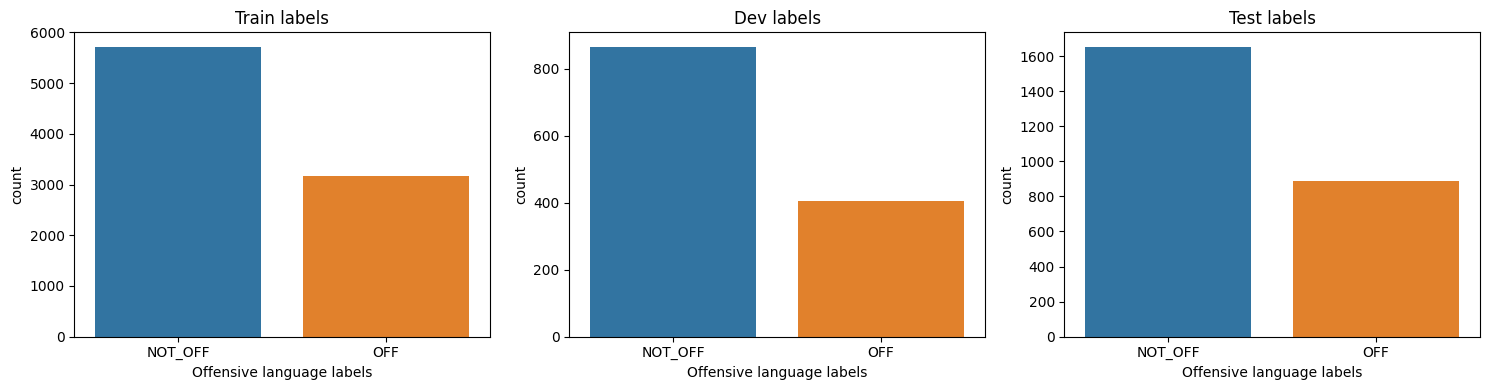

(8886, 12) (1269, 4) (2540, 4)
0    5715
1    3171
Name: class, dtype: int64


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(data=train, x='Offensive', ax=axes[0])
axes[0].set_xlabel('Offensive language labels')
axes[0].set_title('Train labels')

sns.countplot(data=dev, x='Offensive', ax=axes[1])
axes[1].set_xlabel('Offensive language labels')
axes[1].set_title('Dev labels')

sns.countplot(data=test, x='Offensive', ax=axes[2])
axes[2].set_xlabel('Offensive language labels')
axes[2].set_title('Test labels')

plt.tight_layout()
plt.show()
print(train.shape, dev.shape, test.shape)
print(train['class'].value_counts())

#### Data Balancing

In [ ]:
# oversampling
y = train['class']
x = train.drop('class', axis=1)

oversampler = RandomOverSampler(random_state=42)
x_oversample, y_oversample = oversampler.fit_resample(x, y)

train_oversample = pd.DataFrame(x_oversample)
train_oversample['class'] = y_oversample

train_oversample['class'].value_counts()

0    5715
1    5715
Name: class, dtype: int64

In [ ]:
# undersampling
y = train['class']
x = train.drop('class', axis=1)

undersampler = RandomUnderSampler(random_state=42)
x_undersample, y_undersample = undersampler.fit_resample(x, y)

train_undersample = pd.DataFrame(x_undersample, columns=x.columns)
train_undersample['class'] = y_undersample

train_undersample['class'].value_counts()

0    3171
1    3171
Name: class, dtype: int64

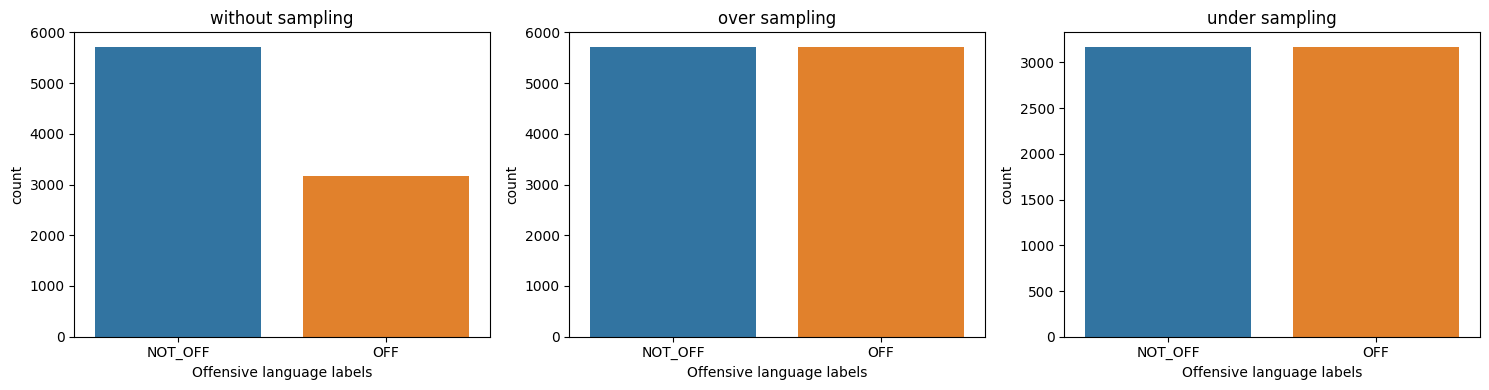

(8886, 12) (11430, 12) (6342, 12)


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.countplot(data=train, x='Offensive', ax=axes[0])
axes[0].set_xlabel('Offensive language labels')
axes[0].set_title('without sampling')

sns.countplot(data=train_oversample, x='Offensive', ax=axes[1])
axes[1].set_xlabel('Offensive language labels')
axes[1].set_title('over sampling')

sns.countplot(data=train_undersample, x='Offensive', ax=axes[2])
axes[2].set_xlabel('Offensive language labels')
axes[2].set_title('under sampling')

plt.tight_layout()
plt.show()
print(train.shape, train_oversample.shape, train_undersample.shape)

## Models:

### ML model(s)

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

In [ ]:
def ml_model_train(model, data, labels):
    text_clf_pip = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', model),])
    text_clf_pip.fit(data, labels)
    return text_clf_pip

def ml_model_eval(model, data, labels):
    pred = model.predict(data)
    accuracy = accuracy_score(labels, pred)
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    return {
        "accuracy":accuracy,
        "precision":precision,
        "recall":recall,
        "f1-score":f1
          }

In [ ]:
def ml_algorithms(data_train, train_labels, data_test, test_labels):

    # decision tree
    decision_tree = DecisionTreeClassifier(max_depth=7)
    decision_tree_model = ml_model_train(decision_tree, data_train, train_labels)
    decision_tree_model_results = ml_model_eval(decision_tree_model, data_test, test_labels)

    # SVC
    svc = SVC()
    svc_model = ml_model_train(svc, data_train, train_labels)
    svc_model_results = ml_model_eval(svc_model, data_test, test_labels)

    # linear SVC
    linearSVC = LinearSVC()
    linearSVC_model = ml_model_train(linearSVC, data_train, train_labels)
    linearSVC_model_results = ml_model_eval(linearSVC_model, data_test, test_labels)

    # random forest
    random_forest = RandomForestClassifier()
    random_forest_model = ml_model_train(random_forest, data_train, train_labels)
    random_forest_model_results = ml_model_eval(random_forest_model, data_test, test_labels)

    # SGD
    sgd = SGDClassifier()
    sgd_model = ml_model_train(sgd, data_train, train_labels)
    sgd_model_results = ml_model_eval(sgd_model,  data_test, test_labels)

    # KNN
    knn = KNeighborsClassifier(5)
    knn_model = ml_model_train(knn, data_train, train_labels)
    knn_model_results = ml_model_eval(knn_model, data_test, test_labels)


    results = {
    'Name': ['Decision tree', 'SVC', 'Linear SVC', 'Random forest', 'SGD', 'KNN'],
    'accuracy': [decision_tree_model_results["accuracy"], svc_model_results["accuracy"], linearSVC_model_results["accuracy"], random_forest_model_results["accuracy"], sgd_model_results["accuracy"], knn_model_results["accuracy"]],
    'precision': [decision_tree_model_results["precision"], svc_model_results["precision"], linearSVC_model_results["precision"], random_forest_model_results["precision"], sgd_model_results["precision"], knn_model_results["precision"]],
    'recall': [decision_tree_model_results["recall"], svc_model_results["recall"], linearSVC_model_results["recall"], random_forest_model_results["recall"], sgd_model_results["recall"], knn_model_results["recall"]],
    'f1-score': [decision_tree_model_results["f1-score"], svc_model_results["f1-score"], linearSVC_model_results["f1-score"], random_forest_model_results["f1-score"], sgd_model_results["f1-score"], knn_model_results["f1-score"]]
    }

    return pd.DataFrame(results)

**Unbalanced data:**

In [ ]:
ml_unbalanced_data_results = ml_algorithms(train["tweet_clean"], train["class"], test["tweet_clean"], test["class"])

In [ ]:
ml_unbalanced_data_results

,Name,accuracy,precision,recall,f1-score
0,Decision tree,0.684252,0.683728,0.179256,0.618138
1,SVC,0.745669,0.741577,0.441939,0.727063
2,Linear SVC,0.768110,0.762543,0.578354,0.762016
3,Random forest,0.721654,0.731538,0.295378,0.679898
4,SGD,0.765748,0.759981,0.553551,0.757703
5,KNN,0.678740,0.672746,0.166855,0.609912


**Oversampled data:**

In [ ]:
ml_undersampled_data_results = ml_algorithms(train_undersample["tweet_clean"], train_undersample["class"], test["tweet_clean"], test["class"])

In [ ]:
ml_undersampled_data_results

,Name,accuracy,precision,recall,f1-score
0,Decision tree,0.629528,0.661051,0.629087,0.637671
1,SVC,0.716535,0.728010,0.667418,0.720411
2,Linear SVC,0.723622,0.737901,0.693348,0.727987
3,Random forest,0.718110,0.713385,0.555806,0.715152
4,SGD,0.718110,0.732080,0.683202,0.722482
5,KNN,0.698819,0.684201,0.397971,0.680443


**Undersampled data:**

In [ ]:
ml_oversampled_data_results = ml_algorithms(train_oversample["tweet_clean"], train_oversample["class"], test["tweet_clean"], test["class"])

In [ ]:
ml_oversampled_data_results

,Name,accuracy,precision,recall,f1-score
0,Decision tree,0.616142,0.666097,0.683202,0.624987
1,SVC,0.752362,0.745458,0.519729,0.742384
2,Linear SVC,0.753937,0.751228,0.621195,0.752313
3,Random forest,0.729528,0.721674,0.419391,0.709824
4,SGD,0.752362,0.750160,0.624577,0.751095
5,KNN,0.682677,0.663239,0.307779,0.651114


**comparison:**

In [ ]:
pd.concat([ml_unbalanced_data_results, ml_undersampled_data_results, ml_oversampled_data_results], axis=1)

,Name,accuracy,precision,recall,f1-score,Name,accuracy,precision,recall,f1-score,Name,accuracy,precision,recall,f1-score
0,Decision tree,0.684252,0.683728,0.179256,0.618138,Decision tree,0.629528,0.661051,0.629087,0.637671,Decision tree,0.616142,0.666097,0.683202,0.624987
1,SVC,0.745669,0.741577,0.441939,0.727063,SVC,0.716535,0.728010,0.667418,0.720411,SVC,0.752362,0.745458,0.519729,0.742384
2,Linear SVC,0.768110,0.762543,0.578354,0.762016,Linear SVC,0.723622,0.737901,0.693348,0.727987,Linear SVC,0.753937,0.751228,0.621195,0.752313
3,Random forest,0.721654,0.731538,0.295378,0.679898,Random forest,0.718110,0.713385,0.555806,0.715152,Random forest,0.729528,0.721674,0.419391,0.709824
4,SGD,0.765748,0.759981,0.553551,0.757703,SGD,0.718110,0.732080,0.683202,0.722482,SGD,0.752362,0.750160,0.624577,0.751095
5,KNN,0.678740,0.672746,0.166855,0.609912,KNN,0.698819,0.684201,0.397971,0.680443,KNN,0.682677,0.663239,0.307779,0.651114


### Transformer model(s)

In [ ]:
! pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 22.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer , TrainingArguments
from transformers.data.processors import SingleSentenceClassificationProcessor, InputFeatures
from transformers import AutoConfig, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

#### Helper functions:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def prep_transformer(model_name, num_labels, tok_max_len):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.max_len = tok_max_len
    config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
    model = BertForSequenceClassification.from_pretrained(model_name, config=config)
    return model, tokenizer


def prep_transformer_data(data_train, train_labels, data_test, test_labels, tokenizer):
    train_dataset = SingleSentenceClassificationProcessor(mode='classification')
    test_dataset = SingleSentenceClassificationProcessor(mode='classification')

    train_dataset.add_examples(texts_or_text_and_labels=data_train, labels=train_labels, overwrite_examples = True)
    test_dataset.add_examples(texts_or_text_and_labels=data_test, labels=test_labels, overwrite_examples = True)

    train_features = train_dataset.get_features(tokenizer = tokenizer)
    test_features = test_dataset.get_features(tokenizer = tokenizer)

    return {
        "train_features" : train_features,
        "test_features" : test_features,
        "train_dataset" : train_dataset,
        "test_dataset" : test_dataset
        }

def prep_training_args(model_name, optimizer, batch_size, epochs, lg_step, sv_step):
    training_args = TrainingArguments(SAVE_PATH + model_name+"-ck")
    training_args.do_train = True
    training_args.evaluate_during_training = True
    training_args.optim=optimizer
    training_args.per_device_train_batch_size = batch_size
    training_args.per_device_eval_batch_size = batch_size
    training_args.num_train_epochs = epochs
    training_args.logging_steps = lg_step
    training_args.save_steps = sv_step
    training_args.seed = 42
    return training_args



def make_trainer(model, training_args, train_features, test_features, compute_metrics):

    trainer = Trainer(model=model,
                    args = training_args,
                    train_dataset = train_features,
                    eval_dataset = test_features,
                    compute_metrics = compute_metrics)
    return trainer



def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)

    macro_f1 = f1_score(p.label_ids,preds,average='macro')
    macro_precision = precision_score(p.label_ids,preds,average='macro')
    macro_recall = recall_score(p.label_ids,preds,average='macro')
    acc = accuracy_score(p.label_ids,preds)
    return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
    }

#### Bert:

In [ ]:
model_name = "bert-base-multilingual-cased"
num_labels = 2
tok_max_len = 32
batch_size = 32
epochs = 20

bert_model, bert_tokenizer = prep_transformer(model_name, num_labels, tok_max_len)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Unbalanced data:**

In [ ]:
transformer_data = prep_transformer_data(train["tweet_clean"], train["class"], test["tweet_clean"], test["class"], bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
print(transformer_data["train_dataset"].examples[10])
print(transformer_data["train_features"][10])

InputExample(guid=None, text_a='وهو صادق من يسب الصحابه ويدعي تحريف القران ويتهم عاءشه بالزنا وش نسميه مسلم مطور مثلا الا بيض الله وجهه كلامه صحيح وماقال الا الحق ياالبقره قبضه قادمه', text_b=None, label=1)
InputFeatures(input_ids=[101, 15430, 777, 85042, 10289, 793, 40828, 59901, 104923, 10388, 791, 14472, 32160, 766, 48416, 20884, 59901, 30506, 10765, 791, 68643, 10700, 781, 12700, 11626, 10388, 10909, 48838, 14695, 791, 11626, 102], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], token_type_ids=None, label=1)


In [ ]:
trainer.train()

Step,Training Loss
300,0.166500
600,0.171200
900,0.163000
1200,0.130100
1500,0.155700
1800,0.155300
2100,0.125300
2400,0.132000
2700,0.113300
3000,0.090300


TrainOutput(global_step=5560, training_loss=0.10408808447474198, metrics={'train_runtime': 1390.9127, 'train_samples_per_second': 127.772, 'train_steps_per_second': 3.997, 'total_flos': 2922506047411200.0, 'train_loss': 0.10408808447474198, 'epoch': 20.0})

In [ ]:
bert_multiling_unbal_data_res = trainer.evaluate()

In [ ]:
bert_multiling_unbal_data_res

{'eval_loss': 1.159873604774475,
 'eval_macro_f1': 0.722429772159841,
 'eval_macro_precision': 0.7285402327761645,
 'eval_macro_recall': 0.7181350433191402,
 'eval_accuracy': 0.7531496062992126,
 'eval_runtime': 4.4399,
 'eval_samples_per_second': 572.09,
 'eval_steps_per_second': 18.019,
 'epoch': 20.0}

In [ ]:
torch.save(bert_model, SAVE_PATH + model_name+"_unba_data.pt")

**Undersampled data:**

In [ ]:
transformer_data = prep_transformer_data(train_undersample["tweet_clean"], train_undersample["class"], test["tweet_clean"], test["class"], bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
300,0.192000
600,0.328000
900,0.247600
1200,0.180300
1500,0.155900
1800,0.133600
2100,0.089000
2400,0.078400
2700,0.077400
3000,0.074200


TrainOutput(global_step=3980, training_loss=0.13362909884908092, metrics={'train_runtime': 978.3109, 'train_samples_per_second': 129.652, 'train_steps_per_second': 4.068, 'total_flos': 2085812891366400.0, 'train_loss': 0.13362909884908092, 'epoch': 20.0})

In [ ]:
bert_multiling_under_data_res = trainer.evaluate()

In [ ]:
bert_multiling_under_data_res

{'eval_loss': 1.166223406791687,
 'eval_macro_f1': 0.7190822287534087,
 'eval_macro_precision': 0.7254013997529848,
 'eval_macro_recall': 0.7147115933518436,
 'eval_accuracy': 0.7503937007874015,
 'eval_runtime': 4.3944,
 'eval_samples_per_second': 578.007,
 'eval_steps_per_second': 18.205,
 'epoch': 20.0}

In [ ]:
torch.save(bert_model, SAVE_PATH + model_name+"_under_data.pt")

**Oversampled data:**

In [ ]:
transformer_data = prep_transformer_data(train_oversample["tweet_clean"], train_oversample["class"], test["tweet_clean"], test["class"], bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
300,0.187600
600,0.379300
900,0.674100
1200,0.698400
1500,0.700900
1800,0.700300
2100,0.698300
2400,0.698800
2700,0.700400
3000,0.697200


TrainOutput(global_step=7160, training_loss=0.6618926112212282, metrics={'train_runtime': 1868.5096, 'train_samples_per_second': 122.343, 'train_steps_per_second': 3.832, 'total_flos': 3759199203456000.0, 'train_loss': 0.6618926112212282, 'epoch': 20.0})

In [ ]:
bert_multiling_over_data_res = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bert_multiling_over_data_res

{'eval_loss': 0.6936748623847961,
 'eval_macro_f1': 0.2588269623577473,
 'eval_macro_precision': 0.17460629921259843,
 'eval_macro_recall': 0.5,
 'eval_accuracy': 0.34921259842519686,
 'eval_runtime': 4.4128,
 'eval_samples_per_second': 575.598,
 'eval_steps_per_second': 18.129,
 'epoch': 20.0}

In [ ]:
torch.save(bert_model, SAVE_PATH + model_name+"_over_data.pt")

#### AraBertv2:

In [ ]:
model_name = "aubmindlab/bert-base-arabertv02"
num_labels = 2
tok_max_len = 32
batch_size = 32
epochs = 20

ara_bert_model, ara_bert_tokenizer = prep_transformer(model_name, num_labels, tok_max_len)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Unbalanced data:**

In [ ]:
transformer_data = prep_transformer_data(train["tweet_clean"], train["class"], test["tweet_clean"], test["class"], ara_bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(ara_bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
print(transformer_data["train_dataset"].examples[10])
print(transformer_data["train_features"][10])

InputExample(guid=None, text_a='وهو صادق من يسب الصحابه ويدعي تحريف القران ويتهم عاءشه بالزنا وش نسميه مسلم مطور مثلا الا بيض الله وجهه كلامه صحيح وماقال الا الحق ياالبقره قبضه قادمه', text_b=None, label=1)
InputFeatures(input_ids=[2, 747, 9535, 306, 21153, 857, 2161, 4228, 578, 53693, 40802, 28198, 4178, 224, 10753, 11573, 325, 908, 43875, 5533, 3043, 328, 4612, 335, 32048, 647, 11439, 16564, 5092, 1177, 1190, 3], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], token_type_ids=None, label=1)


In [ ]:
trainer.train()

Step,Training Loss
300,0.487500
600,0.341600
900,0.218800
1200,0.151000
1500,0.095600
1800,0.070700
2100,0.048100
2400,0.039100
2700,0.030500
3000,0.022600


TrainOutput(global_step=5560, training_loss=0.0849483102506442, metrics={'train_runtime': 1219.0647, 'train_samples_per_second': 145.784, 'train_steps_per_second': 4.561, 'total_flos': 2922506047411200.0, 'train_loss': 0.0849483102506442, 'epoch': 20.0})

In [ ]:
ara_bert_multiling_unbal_data_res = trainer.evaluate()

In [ ]:
ara_bert_multiling_unbal_data_res

{'eval_loss': 1.4569486379623413,
 'eval_macro_f1': 0.805009693871505,
 'eval_macro_precision': 0.8073712624584717,
 'eval_macro_recall': 0.8028827365229152,
 'eval_accuracy': 0.824015748031496,
 'eval_runtime': 4.4047,
 'eval_samples_per_second': 576.663,
 'eval_steps_per_second': 18.163,
 'epoch': 20.0}

In [ ]:
torch.save(ara_bert_model, SAVE_PATH + model_name+"_unba_data.pt")

**Undersampled data:**

In [ ]:
transformer_data = prep_transformer_data(train_undersample["tweet_clean"], train_undersample["class"], test["tweet_clean"], test["class"], ara_bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(ara_bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
300,0.046400
600,0.037100
900,0.037500
1200,0.035400
1500,0.022700
1800,0.017600
2100,0.004800
2400,0.006800
2700,0.002500
3000,0.003600


TrainOutput(global_step=3980, training_loss=0.01646346336689277, metrics={'train_runtime': 858.1112, 'train_samples_per_second': 147.813, 'train_steps_per_second': 4.638, 'total_flos': 2085812891366400.0, 'train_loss': 0.01646346336689277, 'epoch': 20.0})

In [ ]:
ara_bert_multiling_under_data_res = trainer.evaluate()

In [ ]:
ara_bert_multiling_under_data_res

{'eval_loss': 1.7793283462524414,
 'eval_macro_f1': 0.8072249621416977,
 'eval_macro_precision': 0.807305499220714,
 'eval_macro_recall': 0.8071447424688534,
 'eval_accuracy': 0.8248031496062992,
 'eval_runtime': 4.3786,
 'eval_samples_per_second': 580.099,
 'eval_steps_per_second': 18.271,
 'epoch': 20.0}

In [ ]:
torch.save(ara_bert_model, SAVE_PATH + model_name+"_under_data.pt")

**Oversampled data:**

In [ ]:
transformer_data = prep_transformer_data(train_oversample["tweet_clean"], train_oversample["class"], test["tweet_clean"], test["class"], ara_bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(ara_bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
300,0.049500
600,0.039700
900,0.036000
1200,0.025700
1500,0.021200
1800,0.047000
2100,0.035400
2400,0.034600
2700,0.031600
3000,0.018500


TrainOutput(global_step=7160, training_loss=0.021627040914983058, metrics={'train_runtime': 1571.8295, 'train_samples_per_second': 145.436, 'train_steps_per_second': 4.555, 'total_flos': 3759199203456000.0, 'train_loss': 0.021627040914983058, 'epoch': 20.0})

In [ ]:
ara_bert_multiling_over_data_res = trainer.evaluate()

In [ ]:
ara_bert_multiling_over_data_res

{'eval_loss': 1.208736777305603,
 'eval_macro_f1': 0.8013108270475937,
 'eval_macro_precision': 0.8082711333666266,
 'eval_macro_recall': 0.7959672925656676,
 'eval_accuracy': 0.8228346456692913,
 'eval_runtime': 4.4153,
 'eval_samples_per_second': 575.275,
 'eval_steps_per_second': 18.119,
 'epoch': 20.0}

In [ ]:
torch.save(ara_bert_model, SAVE_PATH + model_name+"_over_data.pt")

#### MarBertv2:

In [ ]:
model_name = "UBC-NLP/MARBERTv2"
num_labels = 2
tok_max_len = 32
batch_size = 32
epochs = 20

mar_bert_model, mar_bert_tokenizer = prep_transformer(model_name, num_labels, tok_max_len)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Unbalanced data:**

In [ ]:
transformer_data = prep_transformer_data(train["tweet_clean"], train["class"], test["tweet_clean"], test["class"], mar_bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(mar_bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
print(transformer_data["train_dataset"].examples[10])
print(transformer_data["train_features"][10])

InputExample(guid=None, text_a='وهو صادق من يسب الصحابه ويدعي تحريف القران ويتهم عاءشه بالزنا وش نسميه مسلم مطور مثلا الا بيض الله وجهه كلامه صحيح وماقال الا الحق ياالبقره قبضه قادمه', text_b=None, label=1)
InputFeatures(input_ids=[2, 2336, 7128, 1939, 16905, 43181, 53891, 69076, 2948, 48881, 3125, 1025, 4286, 10776, 1934, 2254, 49921, 2901, 78599, 4992, 1945, 7461, 1944, 6503, 4773, 2642, 48362, 1929, 1945, 3200, 34194, 3], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], token_type_ids=None, label=1)


In [ ]:
trainer.train()

In [ ]:
mar_bert_multiling_unbal_data_res = trainer.evaluate()

In [ ]:
mar_bert_multiling_unbal_data_res

{'eval_loss': 1.4272944927215576,
 'eval_macro_f1': 0.822332606822444,
 'eval_macro_precision': 0.8196732844620168,
 'eval_macro_recall': 0.8254030286227562,
 'eval_accuracy': 0.837007874015748,
 'eval_runtime': 4.5229,
 'eval_samples_per_second': 561.585,
 'eval_steps_per_second': 17.688,
 'epoch': 20.0}

In [ ]:
torch.save(mar_bert_model, SAVE_PATH + model_name+"_unba_data.pt")

**Undersampled data:**

In [ ]:
transformer_data = prep_transformer_data(train_undersample["tweet_clean"], train_undersample["class"], test["tweet_clean"], test["class"], mar_bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(mar_bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
300,0.384300
600,0.174500
900,0.070300
1200,0.037200
1500,0.020200
1800,0.014200
2100,0.010200
2400,0.008400
2700,0.006700
3000,0.004800


TrainOutput(global_step=3980, training_loss=0.0555547193535159, metrics={'train_runtime': 914.0585, 'train_samples_per_second': 138.766, 'train_steps_per_second': 4.354, 'total_flos': 2085812891366400.0, 'train_loss': 0.0555547193535159, 'epoch': 20.0})

In [ ]:
mar_bert_multiling_under_data_res = trainer.evaluate()

In [ ]:
mar_bert_multiling_under_data_res

{'eval_loss': 1.582589864730835,
 'eval_macro_f1': 0.8093211075775762,
 'eval_macro_precision': 0.8031403763407654,
 'eval_macro_recall': 0.8213602953463042,
 'eval_accuracy': 0.8208661417322834,
 'eval_runtime': 4.3693,
 'eval_samples_per_second': 581.323,
 'eval_steps_per_second': 18.309,
 'epoch': 20.0}

In [ ]:
torch.save(mar_bert_model, SAVE_PATH + model_name+"_under_data.pt")

**Oversampled data:**

In [ ]:
transformer_data = prep_transformer_data(train_oversample["tweet_clean"], train_oversample["class"], test["tweet_clean"], test["class"], mar_bert_tokenizer)
training_args = prep_training_args(model_name, "adamw_torch", batch_size, epochs, 300, 1000)
trainer =  make_trainer(mar_bert_model, training_args, transformer_data["train_features"], transformer_data["test_features"], compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
300,0.137600
600,0.075400
900,0.045600
1200,0.033600
1500,0.016200
1800,0.016800
2100,0.012000
2400,0.019700
2700,0.008200
3000,0.019300


TrainOutput(global_step=7160, training_loss=0.018811790041583877, metrics={'train_runtime': 1661.8967, 'train_samples_per_second': 137.554, 'train_steps_per_second': 4.308, 'total_flos': 3759199203456000.0, 'train_loss': 0.018811790041583877, 'epoch': 20.0})

In [ ]:
mar_bert_multiling_over_data_res = trainer.evaluate()

In [ ]:
mar_bert_multiling_over_data_res

{'eval_loss': 1.5543113946914673,
 'eval_macro_f1': 0.8090358510268013,
 'eval_macro_precision': 0.8166654914956792,
 'eval_macro_recall': 0.8032404612978623,
 'eval_accuracy': 0.8299212598425196,
 'eval_runtime': 4.4898,
 'eval_samples_per_second': 565.731,
 'eval_steps_per_second': 17.818,
 'epoch': 20.0}

In [ ]:
torch.save(mar_bert_model, SAVE_PATH + model_name+"_over_data.pt")